# Synthetic Dataset

In [1]:
import sys  
sys.path.insert(0, '../')
import deep_forest
import torch as th
from torch import nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from math import pi
import seaborn as sns
sns.set_theme("notebook")
sns.set_style('whitegrid')

## Generate Data
Here the dataset has $x \sim U(-\pi, \pi)\times U(-1.5, 1.5)$. We then generate labels $y$ as $y = \left[\frac{1}{2}\sin(2x_0) < x_1\right]$. 

In [2]:
# 1000 x 2 ==> batch x features
x = th.rand([1000, 2])
x[:, 0] *= 2*pi
x[:, 0] -= pi
x[:, 1] *= 3
x[:, 1] -= 1.5

# Labels
y = (th.sin(x[:, 0] * 2) * 0.5 < x[:, 1]).long()

## Deep Forest

In [3]:
model = deep_forest.DeepForest(25, 2, 2, 1, 10)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
model = model.to(device)
x = x.to(device)
y = y.to(device)

In [4]:
optimizer = th.optim.Adam(model.parameters())
for i in range(2500):
    model.populate_best(x[:, :], y[:])
    optimizer.zero_grad()

    loss = model.loss(x[:, :], y[:], device)
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print("====EPOCH %d====\nAcc: %s\nLoss: %s" % (i, str(th.mean((model.forward(x[:, :], device) == y[:]).float())), str(loss)))

print("\n==============\nFINAL ACC: %s" % str(th.mean((model.forward(x[:, :], device) == y[:]).float())))

====EPOCH 0====
Acc: tensor(0.7850)
Loss: tensor([93.3672], grad_fn=<AddBackward0>)
====EPOCH 200====
Acc: tensor(0.9000)
Loss: tensor([82.6260], grad_fn=<AddBackward0>)
====EPOCH 400====
Acc: tensor(0.9000)
Loss: tensor([81.8283], grad_fn=<AddBackward0>)
====EPOCH 600====
Acc: tensor(0.9020)
Loss: tensor([81.1963], grad_fn=<AddBackward0>)
====EPOCH 800====
Acc: tensor(0.9060)
Loss: tensor([80.7193], grad_fn=<AddBackward0>)
====EPOCH 1000====
Acc: tensor(0.9190)
Loss: tensor([80.0311], grad_fn=<AddBackward0>)
====EPOCH 1200====
Acc: tensor(0.9360)
Loss: tensor([79.3510], grad_fn=<AddBackward0>)
====EPOCH 1400====
Acc: tensor(0.9450)
Loss: tensor([78.5975], grad_fn=<AddBackward0>)
====EPOCH 1600====
Acc: tensor(0.9540)
Loss: tensor([77.8645], grad_fn=<AddBackward0>)
====EPOCH 1800====
Acc: tensor(0.9620)
Loss: tensor([77.1928], grad_fn=<AddBackward0>)
====EPOCH 2000====
Acc: tensor(0.9710)
Loss: tensor([76.6631], grad_fn=<AddBackward0>)
====EPOCH 2200====
Acc: tensor(0.9760)
Loss: tenso

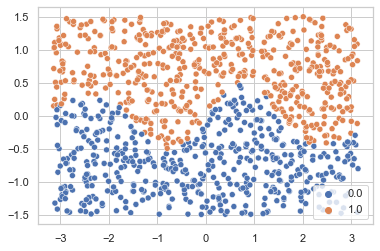

In [5]:
sns.scatterplot(x[:, 0], x[:, 1], hue=model.forward(x, device).cpu().numpy())
plt.show()

In [6]:
imp = model.compute_importance(x)
print()
print(imp)

100%|██████████| 25/25 [02:17<00:00,  5.49s/it]
defaultdict(<function DeepForest.__init__.<locals>.<lambda> at 0x7f8fdf428378>, {0: 0.25434774020438017, 1: 0.7456522597956199})



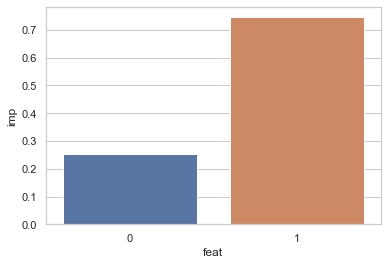

In [7]:
import pandas as pd
data = pd.DataFrame({"feat": list(imp.keys()), "imp": list(imp.values())})
sns.barplot(x="feat", y="imp", data=data)

## MLP Baseline

In [8]:
mlp = nn.Sequential(
    nn.Linear(2, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 2),
    nn.Softmax()
)

optimizer = th.optim.Adam(mlp.parameters())
for i in range(1000):
    optimizer.zero_grad()

    preds = mlp(x[:, :])
    loss = nn.functional.cross_entropy(preds, (y[:].type(th.LongTensor)).to(device))
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print("====EPOCH %d====\nAcc: %s\nLoss: %s" % (i, str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())), str(loss)))

print("\n==============\nFINAL ACC: %s" % str(th.mean((th.argmax(mlp(x[:]), 1) == y[:]).float())))

====EPOCH 0====
Acc: tensor(0.4920)
Loss: tensor(0.6959, grad_fn=<NllLossBackward>)
====EPOCH 100====
Acc: tensor(0.9140)
Loss: tensor(0.5086, grad_fn=<NllLossBackward>)
====EPOCH 200====
Acc: tensor(0.9170)
Loss: tensor(0.4050, grad_fn=<NllLossBackward>)
====EPOCH 300====
Acc: tensor(0.9220)
Loss: tensor(0.3903, grad_fn=<NllLossBackward>)
====EPOCH 400====
Acc: tensor(0.9340)
Loss: tensor(0.3811, grad_fn=<NllLossBackward>)
====EPOCH 500====
Acc: tensor(0.9440)
Loss: tensor(0.3736, grad_fn=<NllLossBackward>)
====EPOCH 600====
Acc: tensor(0.9500)
Loss: tensor(0.3681, grad_fn=<NllLossBackward>)
====EPOCH 700====
Acc: tensor(0.9490)
Loss: tensor(0.3642, grad_fn=<NllLossBackward>)
====EPOCH 800====
Acc: tensor(0.9520)
Loss: tensor(0.3613, grad_fn=<NllLossBackward>)
====EPOCH 900====
Acc: tensor(0.9590)
Loss: tensor(0.3583, grad_fn=<NllLossBackward>)

FINAL ACC: tensor(0.9680)


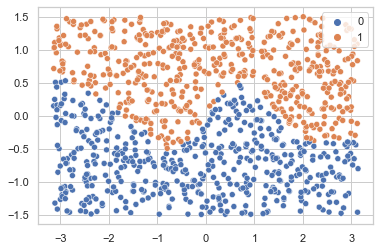

In [9]:
sns.scatterplot(x[:, 0], x[:, 1], hue=th.argmax(mlp(x[:]), 1).cpu().numpy())
plt.show()

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2)
clf.fit(x[:, :].numpy(), y[:].numpy())
print(clf.score(x[:, :].numpy(), y[:].numpy()))

0.922


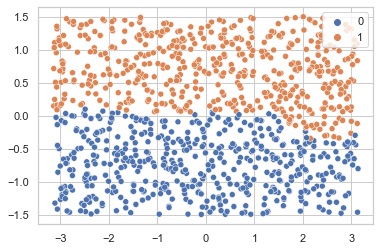

In [11]:
sns.scatterplot(x[:, 0], x[:, 1], hue=clf.predict(x[:, :].numpy()))
plt.show()

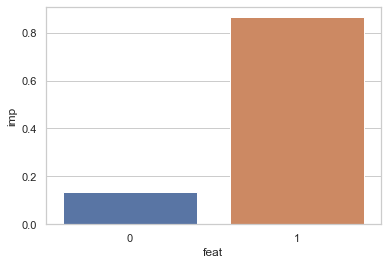

In [12]:
data = pd.DataFrame({"feat": list(range(2)), "imp": clf.feature_importances_})
sns.barplot(x="feat", y="imp", data=data)